In [1]:
import os
import re
import sys
import nltk
import json
import lime
import shap
import pickle
import graphviz
import numpy as np
import pandas as pd 
sys.path.append("..")
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt 
from scipy.stats import spearmanr
from sklearn.utils import resample
from nltk.sentiment import SentimentIntensityAnalyzer
from Simulation.dm_strategies import BOT_ACTION, REVIEWS
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error

/anaconda/envs/final_project_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dir_path = os.path.dirname(os.getcwd())
DATA_CLEAN_ACTION_PATH_X = f"{dir_path}/data/games_clean_X.csv"
DATA_GAME_REVIEWS_PATH = f"{dir_path}/data/game_reviews"

reaction_time_bins = [(0, 400),
                      (400, 800),
                      (800, 1200),
                      (1200, 1600),
                      (1600, 2500),
                      (2500, 4000),
                      (4000, 6000),
                      (6000, 12000),
                      (12000, 20000),
                      (20000, np.inf)]

with open(f"{dir_path}/data/baseline_proba2go.txt", 'r') as file:
    PROBA2GO_DICT = json.load(file)

N_HOTELS = 1068

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
REVIEWS_DICT = dict()

for hotel_id in range(1, N_HOTELS + 1):
    hotel_df = pd.read_csv(os.path.join(DATA_GAME_REVIEWS_PATH, f'{hotel_id}.csv'), names=['reviewId', 'hotelId', 'positive', 'negative', 'score'])
    reviews = hotel_df['reviewId'].unique()
    for review_id in reviews:
        review_row = hotel_df.loc[hotel_df['reviewId'] == review_id]
        review_score = review_row['score'].iloc[0]
        positive_review = review_row['positive'].fillna('').iloc[0]
        negative_review = review_row['negative'].fillna('').iloc[0]
        review = positive_review + ' ' + negative_review
        review_sentiment_scores = sia.polarity_scores(review)
        positive_len = len(positive_review)
        negative_len = len(negative_review)
        total_len = len(positive_review) + len(negative_review)
        review_count = len(re.sub(r'[^\w\s]', '', review).split())
        REVIEWS_DICT[review_id] = {'positive_len': positive_len, 'negative_len': negative_len, 
                                   'review_length': total_len, 'word_count': review_count, 
                                     'positive_review_proportion': positive_len / total_len if total_len != 0 else 0, 
                                   'negative_review_proportion': negative_len / total_len if total_len != 0 else 0, 
                                   'positive_negative_proportion': positive_len / negative_len if negative_len != 0 else positive_len, 
                                   'negative_positive_proportion': negative_len / positive_len if positive_len != 0 else negative_len,
                                   'negative_score': review_sentiment_scores['neg'], 'positive_score': review_sentiment_scores['pos'], 
                                   'neutral_score': review_sentiment_scores['neu'], 'compound_score': review_sentiment_scores['compound'], 
                                   'review_score': review_score}

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Loading the data

In [15]:
X_df = pd.read_csv(DATA_CLEAN_ACTION_PATH_X)
X_df['user_id'] = X_df['user_id'].apply(lambda x: 'X_' + str(x))
labels = range(len(reaction_time_bins) + 1)
bin_edges = [-1] + [b[0] for b in reaction_time_bins] + [reaction_time_bins[-1][1]]
bin_labels = ["-1-0"] + [f"{b[0]}-{b[1]}" if b[1] != np.inf else f"{b[0]}+" for b in reaction_time_bins]

### Adding Reviews Features

In [17]:
hotel_dfs = dict()

def add_review_prob(row):
    review_id = row['reviewId']
    return PROBA2GO_DICT[str(review_id)]

def get_review_scores(row):
    review_id = row['reviewId']
    review_scores_dict = REVIEWS_DICT[review_id]
    return review_scores_dict

### Adding Mistakes Features

In [18]:
def add_mistakes_columns(df):
    # Calculate the cumulative sum of mistakes, then shift within each group so the calculation will be correct to the start of the round
    df['mistakes_cumulative'] = df.groupby(['user_id', 'gameId'])['didWin'].transform(lambda x: (~x).cumsum())  
    df['current_game_mistakes_amount'] = df.groupby(['user_id', 'gameId'])['mistakes_cumulative'].shift(fill_value=0)  
    
    # Calculate cumulative mistakes across all games for each user, then shift  
    df['total_mistakes_cumulative'] = df.groupby(['user_id'])['didWin'].transform(lambda x: (~x).cumsum())  
    df['total_games_mistakes_amount'] = df.groupby(['user_id'])['total_mistakes_cumulative'].shift(fill_value=0)  
    
    # For percentage calculations, adjust for the shift by avoiding division by zero  
    df['rounds_so_far'] = df.groupby(['user_id', 'gameId']).cumcount()  
    df['total_rounds_so_far'] = df.groupby(['user_id']).cumcount() 
    df['current_game_mistakes_percentage'] = df['current_game_mistakes_amount'] / df['rounds_so_far'].replace(0, pd.NA)  
    df['total_games_mistakes_percentage'] = df['total_games_mistakes_amount'] / df['total_rounds_so_far'].replace(0, pd.NA)  
    
    # Fill NaN values in the percentage columns  
    df.fillna({'current_game_mistakes_percentage': 0, 'total_games_mistakes_percentage': 0}, inplace=True)  
    df.drop(['mistakes_cumulative', 'total_mistakes_cumulative', 'rounds_so_far', 'total_rounds_so_far'], axis=1, inplace=True)
    return df

### Extracting Players Strategies

In [19]:

def history_and_review_quality(history_window, quality_threshold, information):      
    if len(information["previous_rounds"]) == 0 \
            or history_window == 0 \
            or np.min(np.array([((r[BOT_ACTION] >= 8 and r[REVIEWS] >= 8)
                                    or (r[BOT_ACTION] <= 8 and r[REVIEWS] < 8)) for r in
                                information["previous_rounds"][
                                -history_window:]])) == 1:          
        if information["bot_message"] >= quality_threshold: 
            return 1
        else:
            return 0
    else:
        return 0
    
def LLM_based(information):
    proba2go = {int(k): v for k, v in PROBA2GO_DICT.items()}
    review_llm_score = proba2go[information["review_id"]]
    return int(np.random.rand() <= review_llm_score)


def create_information(group):
    group['information'] = [
        [(hotel_score, review_score) for hotel_score, review_score in zip(group['hotelScore'][:i], group['review_score'][:i])] 
        for i in range(len(group))
    ]
    return group

def calculate_played_oracle(group):
    did_win = group['didWin'].values
    played_oracle = [0] * len(did_win)
    for i in range(1, len(did_win) - 1):
        if all(did_win[i: len(group)]):
            played_oracle[i:] = [1] * (len(group) - i)
            break
    group['played_oracle'] = played_oracle
    return group


def calculate_trustful_and_llm(row, user_properties):
    user_id = row['user_id']
    review_id = row['reviewId']
    bot_message = row['review_score']
    history_window = user_properties[user_id]['history_window']
    quality_threshold = user_properties[user_id]['quality_threshold']
    information = {'previous_rounds': row['information'], 'bot_message': bot_message, 'review_id': review_id}
    
    trustful_decision = history_and_review_quality(history_window, quality_threshold, information)
    llm_decision = LLM_based(information)
    
    return pd.Series([trustful_decision, llm_decision])


def lost_cause(row, strategy_threshold_dict):
    if 10 - strategy_threshold_dict[row['strategy_id']] < row['current_game_mistakes_amount']:
        return 1 
    else:
        return 0

### Adding All features

In [20]:
def pre_process(actions_df, bot_thresholds):
    actions_df['reaction_time_bins'] = pd.cut(actions_df['reaction_time'], bins=bin_edges, include_lowest=True)
    actions_df['last_reaction_time_bins'] = pd.cut(actions_df['last_reaction_time'], bins=bin_edges, include_lowest=True)
    actions_df['last_reaction_time_bins_categories'] = actions_df['last_reaction_time_bins'].apply(lambda x: (x.left))
    actions_df['reaction_time_bins_categories'] = actions_df['reaction_time_bins'].apply(lambda x: (x.left))
    scores_series = actions_df.apply(get_review_scores, axis=1)
    scores_df = pd.DataFrame(scores_series.tolist())
    actions_df = pd.concat([actions_df, scores_df], axis=1)
    actions_df = add_mistakes_columns(actions_df)
    actions_df['user_earned_more'] = actions_df['user_points'] >= actions_df['bot_points']
    actions_df['bot_earned_more'] = actions_df['user_points'] < actions_df['bot_points']
    actions_df['review_prob'] = actions_df.apply(add_review_prob, axis=1)

    user_properties = {
    user_id: {
        'history_window': np.random.negative_binomial(2, 1 / 2) + np.random.randint(0, 2),
        'quality_threshold': np.random.normal(8, 0.5),
        'random_noise': np.random.normal(0, 0.1)
    } 
    for user_id in actions_df['user_id'].unique()
    }

    strategies_df = actions_df[['user_id', 'gameId', 'reviewId', 'strategy_id', 'hotelScore', 'review_score', 'didWin', 'didGo']] \
        .groupby(by=['user_id', 'gameId']).apply(create_information).reset_index(drop=True)
    strategies_df = strategies_df.groupby(by=['user_id', 'gameId']).apply(calculate_played_oracle).reset_index(drop=True)
    strategies_df[['trustful_decision', 'llm_decision']] = strategies_df.apply(lambda row: calculate_trustful_and_llm(row, user_properties), axis=1)
    strategies_df['played_trustful'] = (strategies_df['trustful_decision'] == strategies_df['didGo']).astype(int)
    strategies_df['played_llm'] = (strategies_df['llm_decision'] == strategies_df['didGo']).astype(int)
    actions_df = actions_df.merge(strategies_df)
    actions_df['played_random'] = actions_df.apply(lost_cause, args=(bot_thresholds,), axis=1)
    actions_df.loc[actions_df[actions_df['played_oracle'] == 1].index, ['played_trustful', 'played_llm', 'played_random']] = 0
    return actions_df

- random: lost_cause = True 
- oracle: the player only wins from now, at least 3 winnings (excluding the first round). if oracle is true then no other strategy is true 
- LLM: same as in the simulation
- Trustful: once the bot lied, the player won't play trustful anymore

- if trustful then go by llm, else go oposite than llm

In [21]:
bot_thresholds_X = {3: 10, 0: 7, 2: 9, 5: 9, 59: 8, 19: 9}
X_processed_df = pre_process(X_df, bot_thresholds_X)

In [22]:
model_train_df = X_processed_df.sample(frac=0.2, random_state=42)
model_test_df = X_processed_df[~X_processed_df.index.isin(model_train_df.index)]

### EDA

In [23]:
all_features = ['gameId', 'roundNum', 'user_points', 'bot_points', 'last_didGo_True', 'last_last_didGo_True', 'last_didWin_True', 'last_last_didWin_True', 'review_prob', 'review_score',
                'review_length', 'positive_review_proportion','negative_review_proportion','positive_negative_proportion','negative_positive_proportion', 'negative_score',
                'positive_score', 'neutral_score', 'compound_score',
                'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'total_games_mistakes_amount',
                'user_earned_more', 'bot_earned_more', 'last_reaction_time', 'last_reaction_time_bins_categories', 'played_trustful', 'played_llm', 'played_random', 'played_oracle']

regression_label_column = 'reaction_time'
classification_label_column = 'reaction_time_bins_categories'

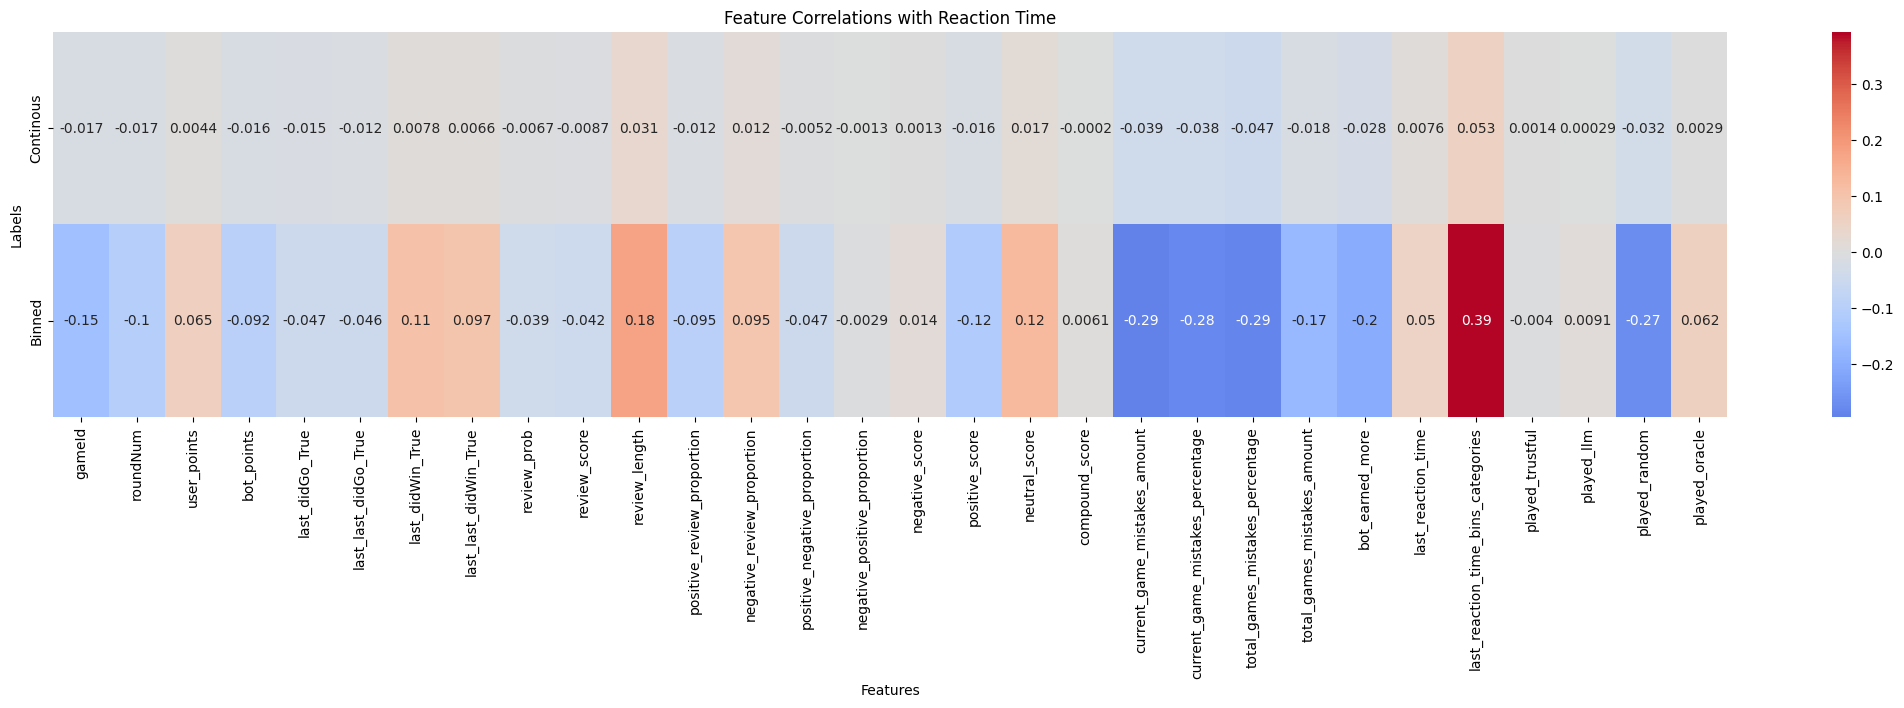

In [24]:
clean_features = ['gameId', 'roundNum', 'user_points', 'bot_points', 'last_didGo_True', 'last_last_didGo_True', 'last_didWin_True', 'last_last_didWin_True', 'review_prob', 'review_score',
                'review_length', 'positive_review_proportion','negative_review_proportion','positive_negative_proportion','negative_positive_proportion', 'negative_score',
                'positive_score', 'neutral_score', 'compound_score',
                'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'total_games_mistakes_amount',
                'bot_earned_more', 'last_reaction_time', 'last_reaction_time_bins_categories', 'played_trustful', 'played_llm', 'played_random', 'played_oracle']

regression_correlations = X_processed_df[clean_features].apply(lambda x: x.corr(X_processed_df[regression_label_column]))
classification_correlations = X_processed_df[clean_features].apply(lambda x: x.corr(X_processed_df[classification_label_column]))
correlations_df = pd.DataFrame({
    'Continous': regression_correlations,
    'Binned': classification_correlations
}).T

plt.figure(figsize=(27, 5))
sns.heatmap(correlations_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations with Reaction Time')
plt.xlabel('Features')
plt.ylabel('Labels')
plt.show()

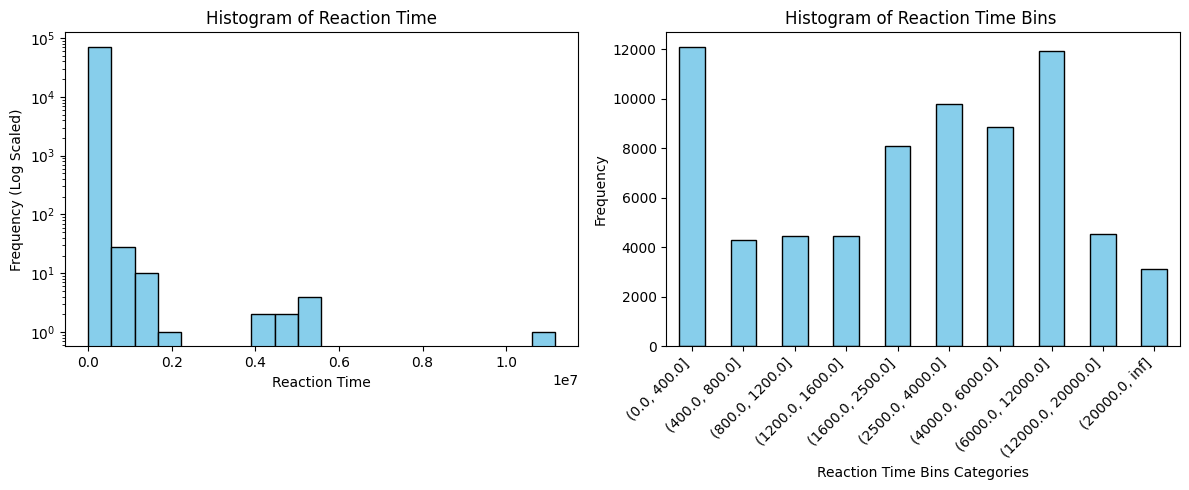

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for the regression label (reaction_time)
axes[0].hist(X_processed_df['reaction_time'], bins=20, color='skyblue', edgecolor='black', log=True)
axes[0].set_title('Histogram of Reaction Time')
axes[0].set_xlabel('Reaction Time')
axes[0].set_ylabel('Frequency (Log Scaled)')

# Plot histogram for the classification label (reaction_time_bins_categories)
bins_count = X_processed_df['reaction_time_bins'].value_counts()
bins_count = bins_count[bins_count > 0]
bins_count.sort_index().plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Histogram of Reaction Time Bins ')
axes[1].set_xlabel('Reaction Time Bins Categories')
axes[1].set_ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
X_processed_df['reaction_time'].describe()

count    7.157900e+04
mean     6.838847e+03
std      7.095936e+04
min      8.000000e+00
25%      9.450000e+02
50%      2.827000e+03
75%      6.488000e+03
max      1.116219e+07
Name: reaction_time, dtype: float64

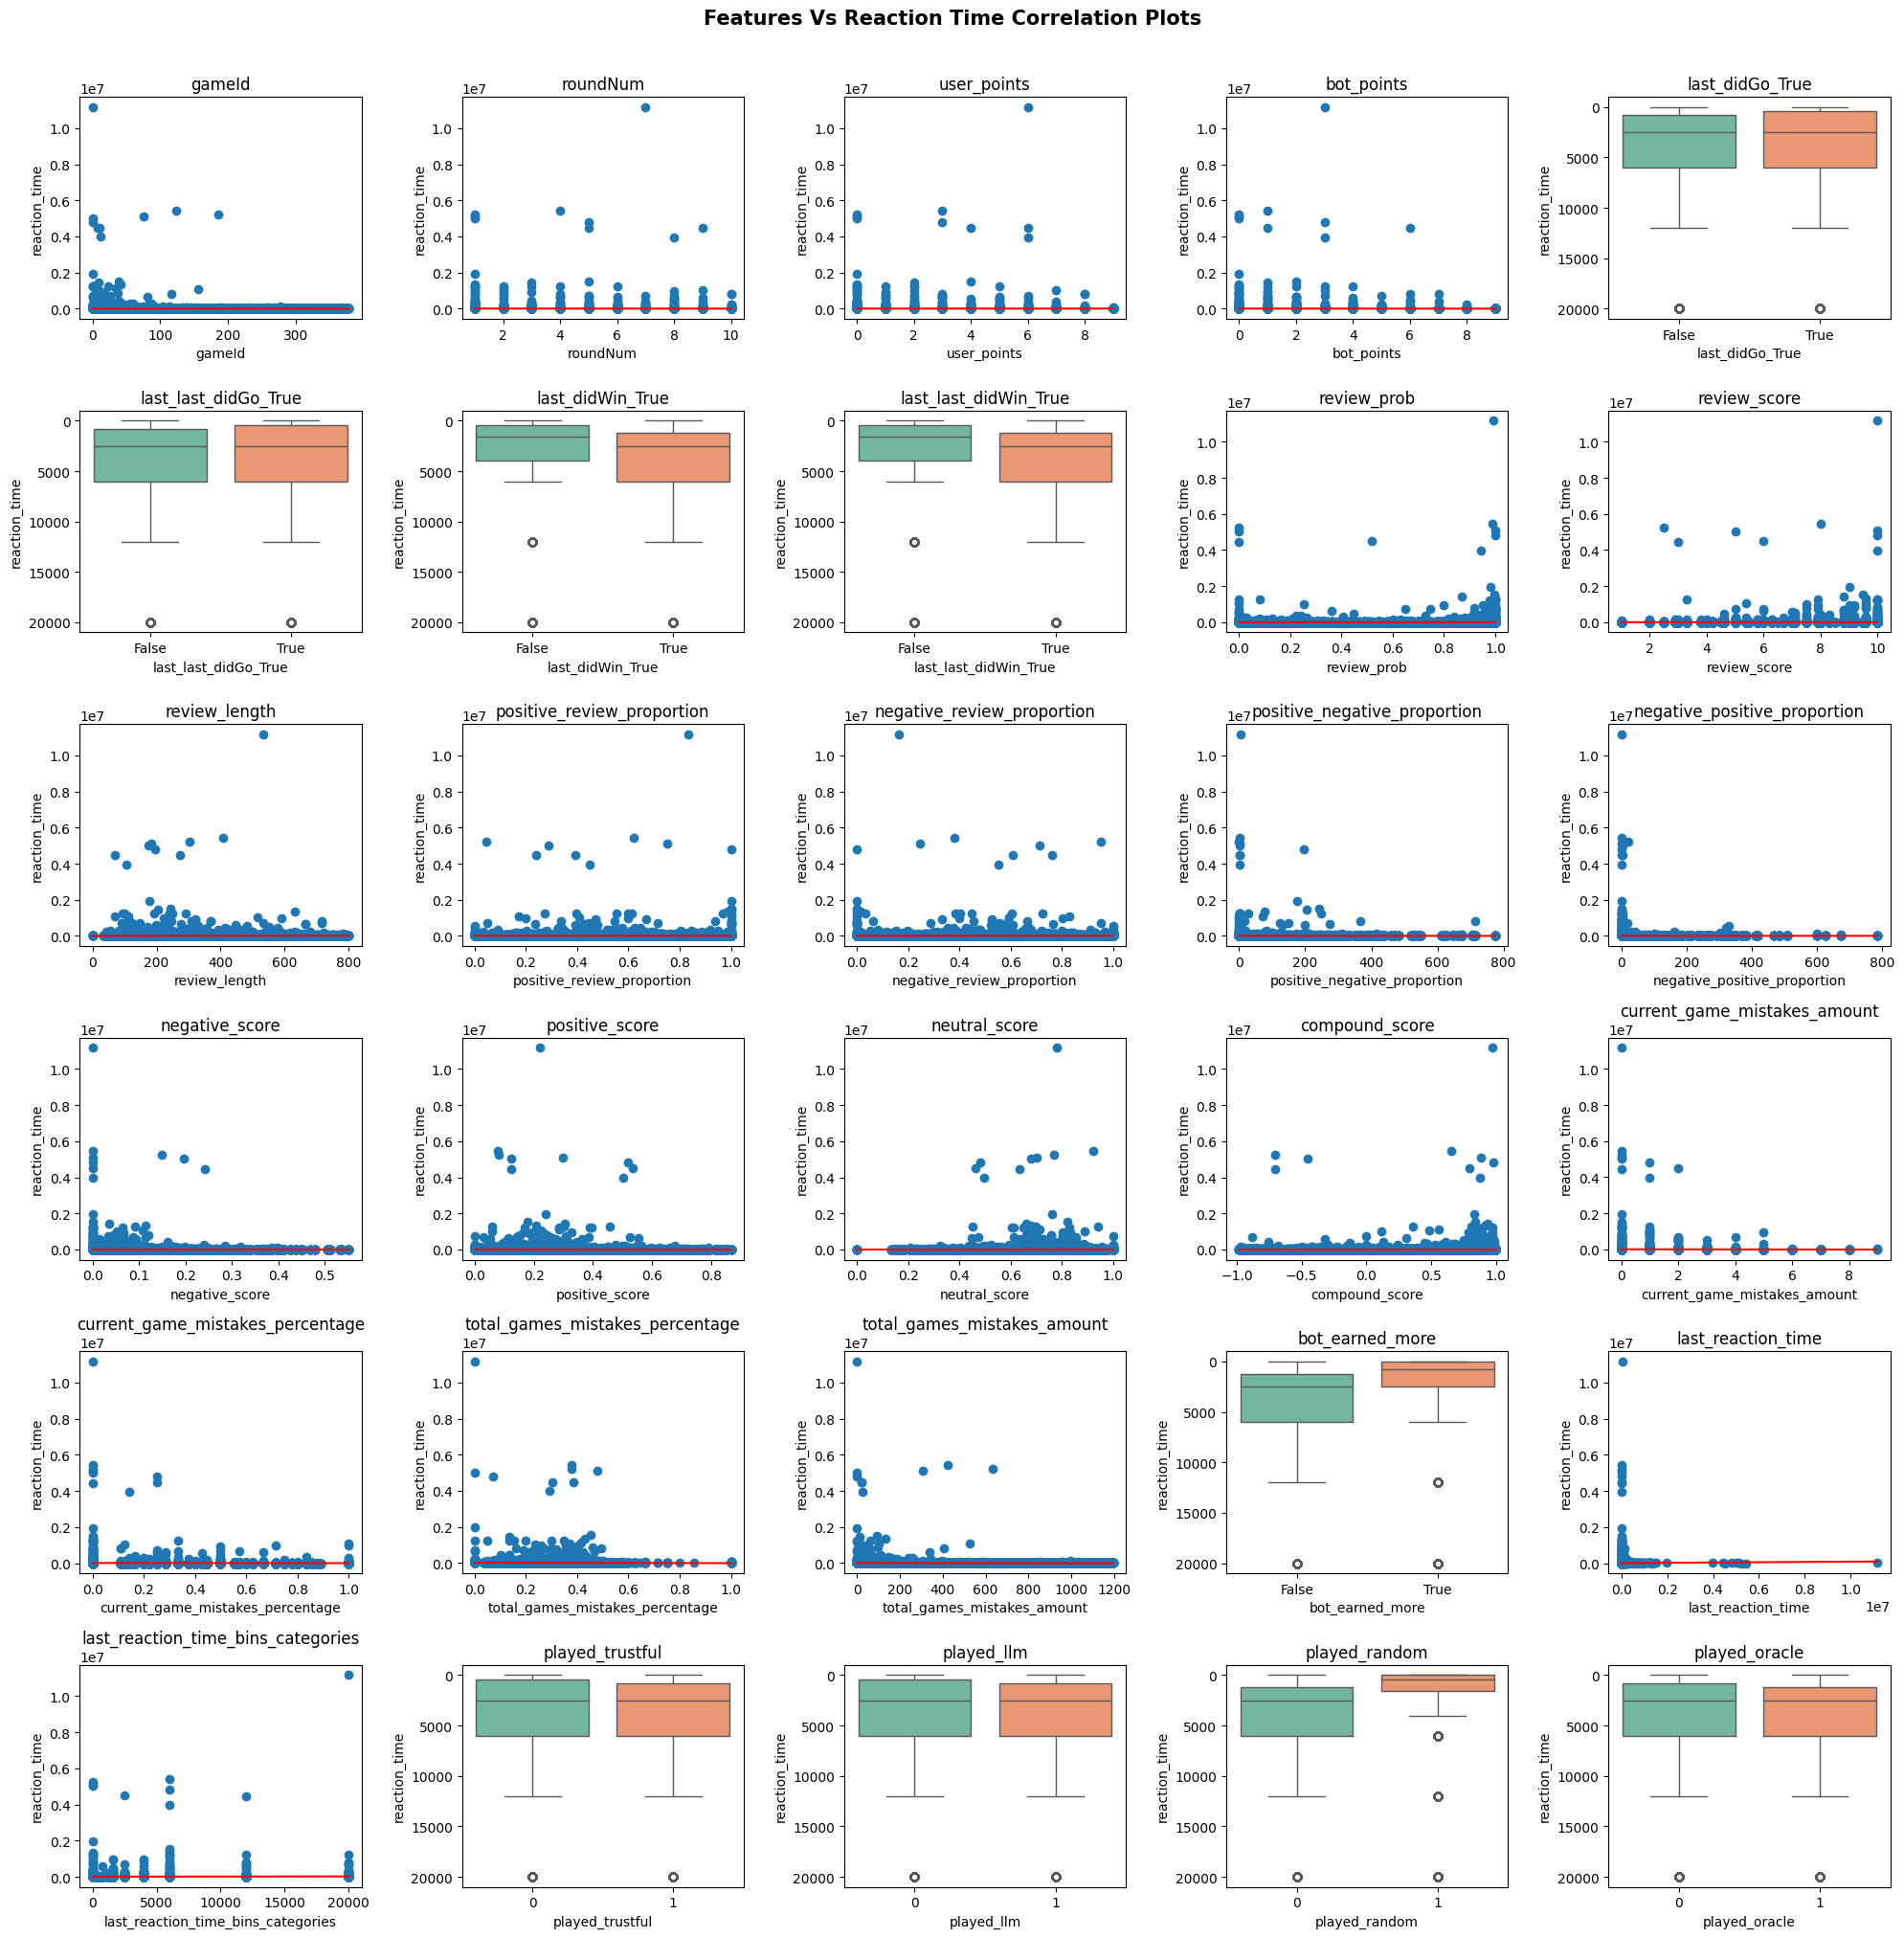

In [30]:
import warnings
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(6, 5, figsize=(20, 20))
axes = axes.flatten()

# Plot correlation plots
for i, feature in enumerate(clean_features):
    if X_processed_df[feature].nunique() > 9:
        coefficients = np.polyfit(X_processed_df[feature], X_processed_df[regression_label_column], 1)
        polynomial = np.poly1d(coefficients)
        x_values = np.linspace(min(X_processed_df[feature]), max(X_processed_df[feature]), 100)
        y_values = polynomial(x_values)
        axes[i].plot(x_values, y_values, color='red', label='Regression Line')
        axes[i].scatter(X_processed_df[feature], X_processed_df[regression_label_column], label='Data Points')
        
    else:
        sns.boxplot(x=X_processed_df[feature].astype(str), y=X_processed_df[classification_label_column], ax=axes[i], palette="Set2")
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(regression_label_column)

#axes[-1].remove()
plt.suptitle('Features Vs Reaction Time Correlation Plots', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



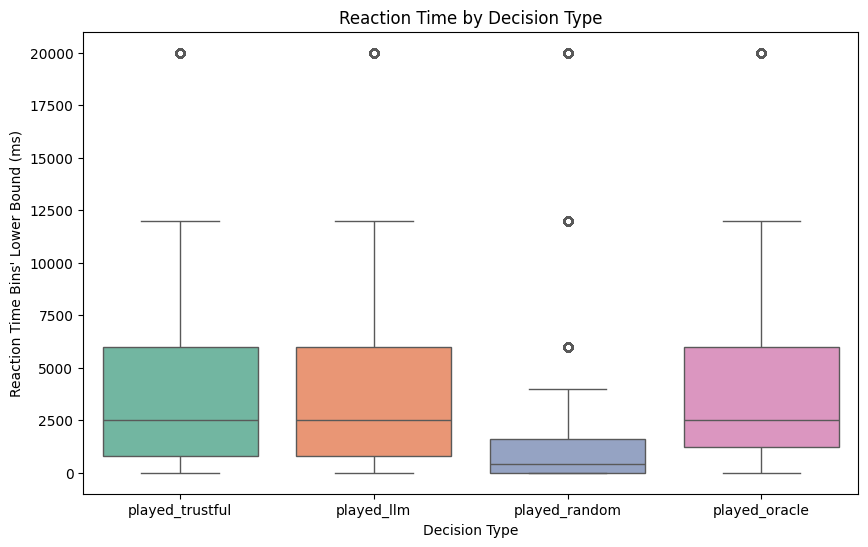

In [67]:
copy_train_df = X_processed_df.copy()
copy_train_df['played_trustful'] = copy_train_df['trustful_decision'].astype(bool)
copy_train_df['played_llm'] = copy_train_df['llm_decision'].astype(bool)
copy_train_df['played_random'] = copy_train_df['played_random'].astype(bool)
copy_train_df['played_oracle'] = copy_train_df['played_oracle'].astype(bool)

# Create a melted DataFrame for easier plotting
melted_df = copy_train_df.melt(
    id_vars=['reaction_time_bins_categories'],
    value_vars=['played_trustful', 'played_llm', 'played_random', 'played_oracle'],
    var_name='decision_type',
    value_name='played'
)

# Filter only true values
melted_df = melted_df[melted_df['played']]
melted_df['reaction_time_bins_categories'] = melted_df['reaction_time_bins_categories'].astype(int)
# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='decision_type', y=classification_label_column, data=melted_df, palette='Set2')
plt.title('Reaction Time by Decision Type')
plt.xlabel('Decision Type')
plt.ylabel("Reaction Time Bins' Lower Bound (ms)")
plt.show()


In [62]:
filtered_df = copy_train_df[
    copy_train_df[['played_trustful', 'played_llm', 'played_random', 'played_oracle']].any(axis=1)
]

stats_data = []
for decision_type in ['played_trustful', 'played_llm', 'played_random', 'played_oracle']:
    group = filtered_df[filtered_df[decision_type]]
    reaction_times = group['reaction_time'].values
    mean = np.mean(reaction_times)
    median = np.median(reaction_times)
    std_dev = np.std(reaction_times)
    n = len(reaction_times)
    conf_interval = stats.t.interval(0.95, n-1, loc=mean, scale=std_dev/np.sqrt(n))
    
    stats_data.append({
        'Decision Type': decision_type,
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_dev,
        '95% CI Lower': conf_interval[0],
        '95% CI Upper': conf_interval[1],
        'CI Width': conf_interval[1] - conf_interval[0]
    })

# Create a DataFrame
df_stats = pd.DataFrame(stats_data)
df_stats

Decision Type         Mean  Median  Standard Deviation  95% CI Lower  \
0  played_trustful  7056.115015  2750.0        83175.795995   6201.668379   
1       played_llm  6553.209789  2730.0        68676.152931   5976.457934   
2    played_random  2814.542029   491.0        37518.582580   2252.871332   
3    played_oracle  7284.240611  3770.0        44528.312043   6499.820131   

   95% CI Upper     CI Width  
0   7910.561650  1708.893271  
1   7129.961644  1153.503710  
2   3376.212726  1123.341394  
3   8068.661090  1568.840959



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



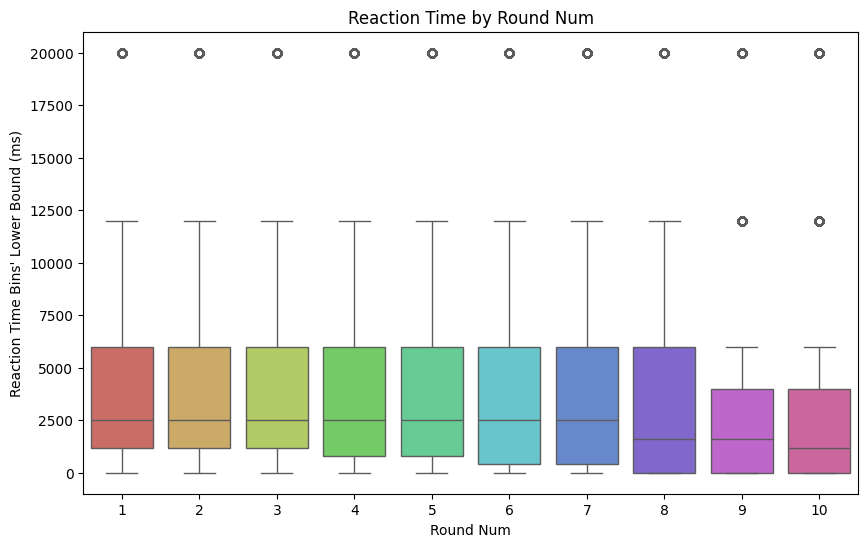

In [11]:
copy_train_df = X_processed_df.copy()
copy_train_df[classification_label_column] = copy_train_df[classification_label_column].astype(int)
copy_train_df = copy_train_df.sort_values(by='roundNum')
copy_train_df['roundNum'] = copy_train_df['roundNum'].astype(str)
plt.figure(figsize=(10, 6))
sns.boxplot(x='roundNum', y=classification_label_column, data=copy_train_df, palette='hls')
plt.title('Reaction Time by Round Num')
plt.xlabel('Round Num')
plt.ylabel("Reaction Time Bins' Lower Bound (ms)")
plt.show()

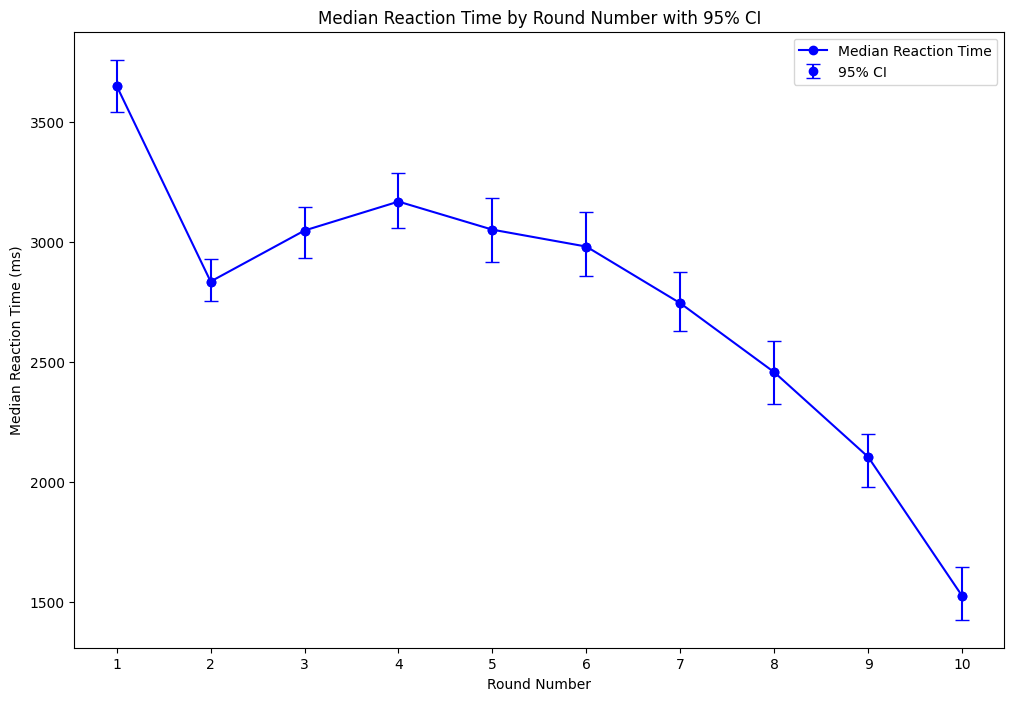

In [42]:
def bootstrap_ci(data, num_bootstraps=1000, alpha=0.05):
    bootstraps = np.random.choice(data, (num_bootstraps, len(data)), replace=True)
    medians = np.median(bootstraps, axis=1)
    lower_bound = np.percentile(medians, 100 * (alpha / 2))
    upper_bound = np.percentile(medians, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

copy_train_df['roundNum'] = copy_train_df['roundNum'].astype(int)

stats_df = copy_train_df.groupby('roundNum')[regression_label_column].apply(lambda x: pd.Series({
    'Median': np.median(x),
    'Lower CI': bootstrap_ci(x)[0],
    'Upper CI': bootstrap_ci(x)[1]
})).reset_index()


stats_df = stats_df.sort_values('roundNum')

medians = stats_df[stats_df['level_1'] == "Median"].reset_index(drop=True)
lower_ci = stats_df[stats_df['level_1'] == "Lower CI"].reset_index(drop=True)
upper_ci = stats_df[stats_df['level_1'] == "Upper CI"].reset_index(drop=True)

plt.figure(figsize=(12, 8))
plt.plot(medians['roundNum'], medians[regression_label_column], marker='o', color='blue', label='Median Reaction Time')
plt.errorbar(medians['roundNum'], medians[regression_label_column], yerr=[medians[regression_label_column] - lower_ci[regression_label_column],
                                                                           upper_ci[regression_label_column] - medians[regression_label_column]],
             fmt='o', color='blue', capsize=5, label='95% CI')
plt.title('Median Reaction Time by Round Number with 95% CI')
plt.xlabel('Round Number')
plt.ylabel('Median Reaction Time (ms)')
plt.xticks(range(1, 11))
plt.legend()
plt.show()


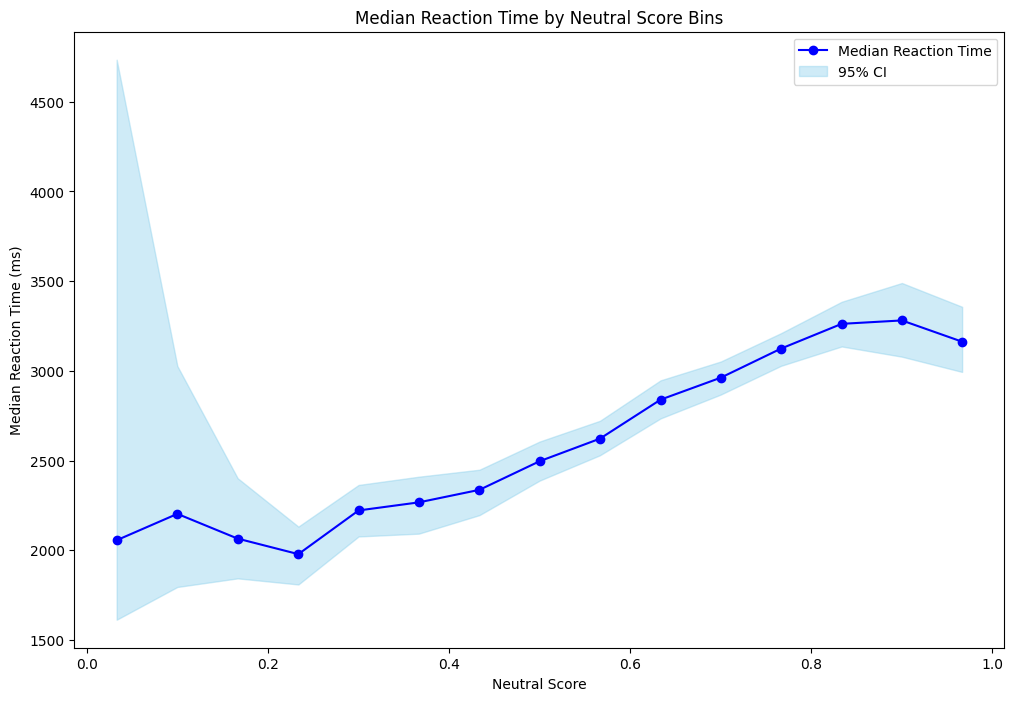

In [76]:
copy_train_df['neutral_score_bins'] = pd.cut(copy_train_df['neutral_score'], bins=15)
def bootstrap_ci(data, n_iterations=1000, ci=95):
    """ Calculate bootstrap confidence intervals for the median """
    bootstrapped_medians = []
    for _ in range(n_iterations):
        sample = resample(data)
        bootstrapped_medians.append(np.median(sample))
    
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    
    ci_lower = np.percentile(bootstrapped_medians, lower_percentile)
    ci_upper = np.percentile(bootstrapped_medians, upper_percentile)
    
    return ci_lower, ci_upper

results = []
for name, group in copy_train_df.groupby('neutral_score_bins')['reaction_time']:
    median_value = np.median(group)
    ci_lower, ci_upper = bootstrap_ci(group)
    results.append({
        'neutral_score_bins': name,
        'median': median_value,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })

stats_df = pd.DataFrame(results)
stats_df['bin_mid'] = stats_df['neutral_score_bins'].apply(lambda x: x.mid)

plt.figure(figsize=(12, 8))
plt.plot(stats_df['bin_mid'], stats_df['median'], marker='o', color='blue', label='Median Reaction Time')
plt.fill_between(stats_df['bin_mid'], stats_df['CI Lower'], stats_df['CI Upper'], color='skyblue', alpha=0.4, label='95% CI')
plt.title('Median Reaction Time by Neutral Score Bins')
plt.xlabel('Neutral Score')
plt.ylabel('Median Reaction Time (ms)')
plt.legend()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



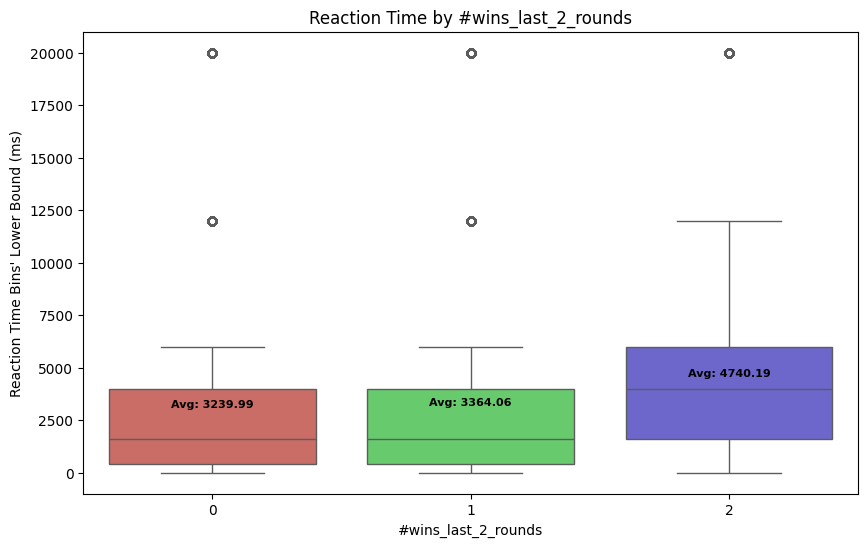

In [44]:
# Create a copy of the dataframe and add a new column
copy_train_df = X_processed_df.copy()
copy_train_df['#wins_last_2_rounds'] = copy_train_df['last_didWin_True'].astype(int) + copy_train_df['last_last_didWin_True'].astype(int)
copy_train_df = copy_train_df.sort_values("#wins_last_2_rounds")
copy_train_df['#wins_last_2_rounds'] = copy_train_df['#wins_last_2_rounds'].astype(str)
copy_train_df[classification_label_column] = copy_train_df[classification_label_column].astype(int)
# Create the boxplot
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(
    x='#wins_last_2_rounds', 
    y=classification_label_column, 
    data=copy_train_df, 
    palette='hls', 
)

# Add mean value text labels
grouped_data = copy_train_df.groupby('#wins_last_2_rounds')[classification_label_column]
means = grouped_data.mean()

for i, mean in enumerate(means):
    plt.text(i, mean, f'Avg: {mean:.2f}', ha='center', va='center', color='black', fontsize=8, weight='bold')

# Customize plot appearance
plt.title('Reaction Time by #wins_last_2_rounds')
plt.xlabel('#wins_last_2_rounds')
plt.ylabel("Reaction Time Bins' Lower Bound (ms)")

# Show plot
plt.show()


rt  \
strategy                                             
LLM stochastic (Language-based)        5841.178945   
correct - oracle                       6281.128623   
history_and_review_quality (Trustful)  5776.595447   
random                                 1290.249343   

                                       reaction_time_bins_categories  
strategy                                                              
LLM stochastic (Language-based)                          4507.476828  
correct - oracle                                         4850.144141  
history_and_review_quality (Trustful)                    4463.936002  
random                                                    917.569729



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



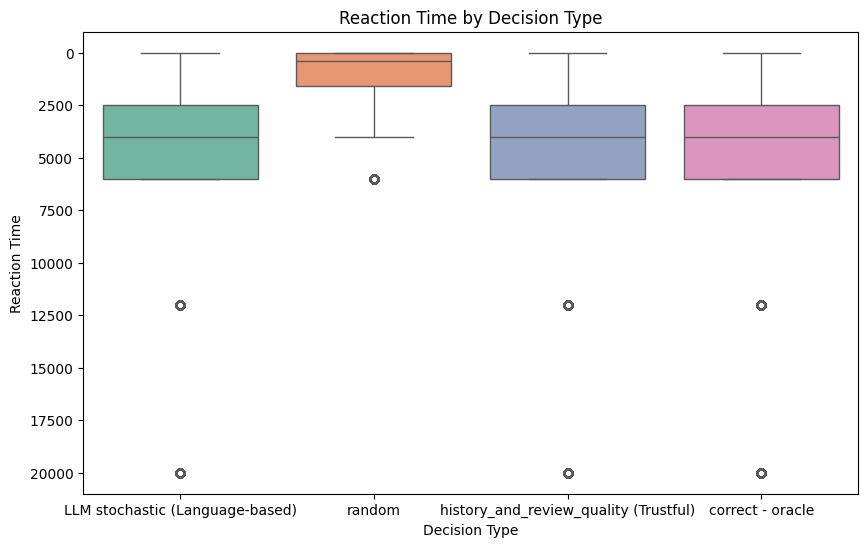

In [14]:
classification_label_column = 'reaction_time_bins_categories'
bin_edges = [-1] + [b[0] for b in reaction_time_bins] + [reaction_time_bins[-1][1]]
simulated_rt_df = pd.read_csv("/home/student/project/HumanChoicePredictionNLP/rt_data/simulated_rt_41.7_0.csv")
simulated_rt_df['reaction_time_bins'] = pd.cut(simulated_rt_df['rt'], bins=bin_edges, include_lowest=True)
simulated_rt_df['reaction_time_bins_categories'] = simulated_rt_df['reaction_time_bins'].apply(lambda x: (x.left)).astype(int)
display(simulated_rt_df.groupby('strategy')[['rt', 'reaction_time_bins_categories']].mean())
plt.figure(figsize=(10, 6))
sns.boxplot(x='strategy', y=classification_label_column, data=simulated_rt_df, palette='Set2')
plt.title('Reaction Time by Decision Type')
plt.xlabel('Decision Type')
plt.ylabel('Reaction Time')
plt.gca().invert_yaxis()
plt.show()

rt  \
strategy                                             
LLM stochastic (Language-based)        8365.698371   
correct - oracle                       8808.824538   
history_and_review_quality (Trustful)  8318.443836   
random                                 1762.863097   

                                       reaction_time_bins_categories  
strategy                                                              
LLM stochastic (Language-based)                          6397.634398  
correct - oracle                                         6719.608460  
history_and_review_quality (Trustful)                    6366.526162  
random                                                   1277.114465



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



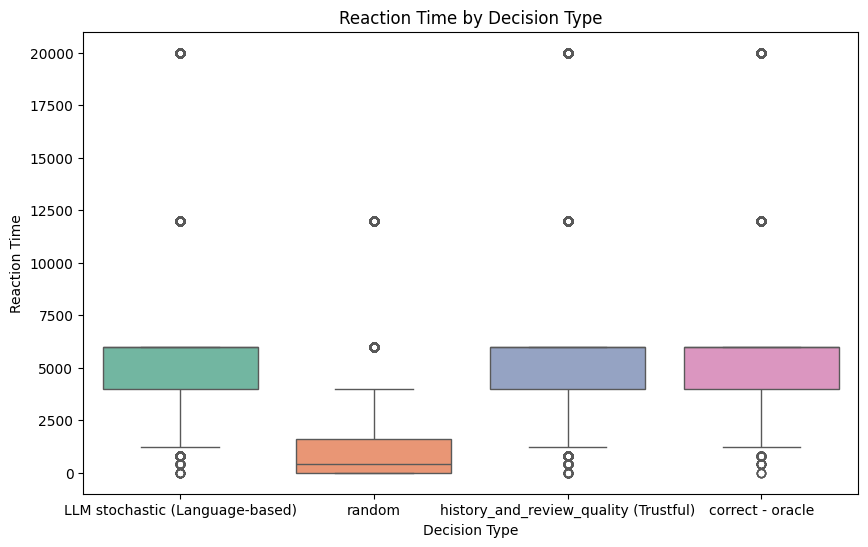

In [6]:
classification_label_column = 'reaction_time_bins_categories'
bin_edges = [-1] + [b[0] for b in reaction_time_bins] + [reaction_time_bins[-1][1]]
simulated_rt_df = pd.read_csv("/home/student/project/HumanChoicePredictionNLP/rt_data/simulated_rt_41.7_250.csv")
simulated_rt_df['reaction_time_bins'] = pd.cut(simulated_rt_df['rt'], bins=bin_edges, include_lowest=True)
simulated_rt_df['reaction_time_bins_categories'] = simulated_rt_df['reaction_time_bins'].apply(lambda x: (x.left)).astype(int)
display(simulated_rt_df.groupby('strategy')[['rt', 'reaction_time_bins_categories']].mean())
plt.figure(figsize=(10, 6))
sns.boxplot(x='strategy', y=classification_label_column, data=simulated_rt_df, palette='Set2')
plt.title('Reaction Time by Decision Type')
plt.xlabel('Decision Type')
plt.ylabel('Reaction Time')
plt.show()

rt  \
strategy                                             
LLM stochastic (Language-based)        7243.671501   
correct - oracle                       7685.400247   
history_and_review_quality (Trustful)  7188.694251   
random                                 1552.812540   

                                       reaction_time_bins_categories  
strategy                                                              
LLM stochastic (Language-based)                          5570.599382  
correct - oracle                                         5906.511256  
history_and_review_quality (Trustful)                    5523.370512  
random                                                   1120.359845



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



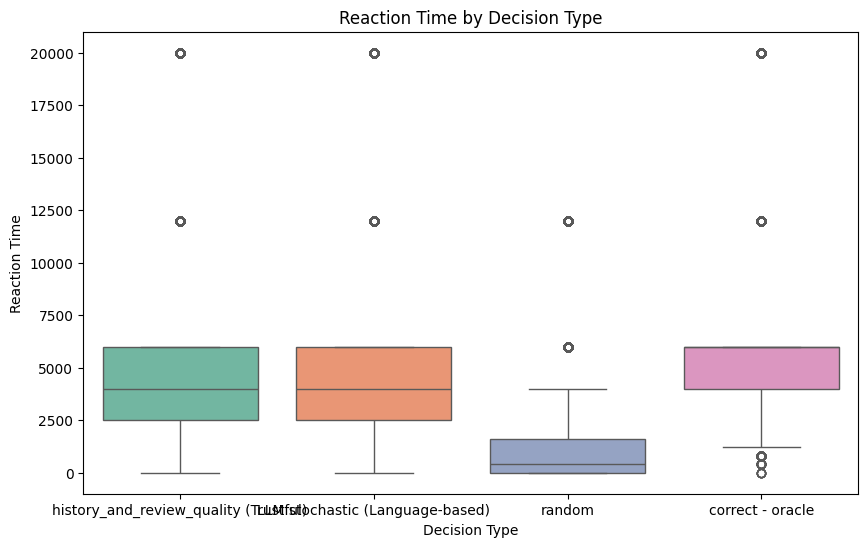

In [11]:
classification_label_column = 'reaction_time_bins_categories'
bin_edges = [-1] + [b[0] for b in reaction_time_bins] + [reaction_time_bins[-1][1]]
simulated_rt_df = pd.read_csv("/home/student/project/HumanChoicePredictionNLP/rt_data/simulated_rt_41.7_300.csv")
simulated_rt_df['reaction_time_bins'] = pd.cut(simulated_rt_df['rt'], bins=bin_edges, include_lowest=True)
simulated_rt_df['reaction_time_bins_categories'] = simulated_rt_df['reaction_time_bins'].apply(lambda x: (x.left)).astype(int)
display(simulated_rt_df.groupby('strategy')[['rt', 'reaction_time_bins_categories']].mean())
plt.figure(figsize=(10, 6))
sns.boxplot(x='strategy', y=classification_label_column, data=simulated_rt_df, palette='Set2', order=["history_and_review_quality (Trustful)", "LLM stochastic (Language-based)", "random", "correct - oracle"])
new_labels = ["played_trustful", "played_llm", "played_random", "played_oracle"]
plt.title('Reaction Time by Decision Type')
plt.xlabel('Decision Type')
plt.ylabel('Reaction Time')
plt.show()

rt  \
strategy                                             
LLM stochastic (Language-based)        6442.240410   
correct - oracle                       6882.958395   
history_and_review_quality (Trustful)  6381.763565   
random                                 1402.776427   

                                       reaction_time_bins_categories  
strategy                                                              
LLM stochastic (Language-based)                          4967.234809  
correct - oracle                                         5304.992531  
history_and_review_quality (Trustful)                    4927.072028  
random                                                   1003.723604



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



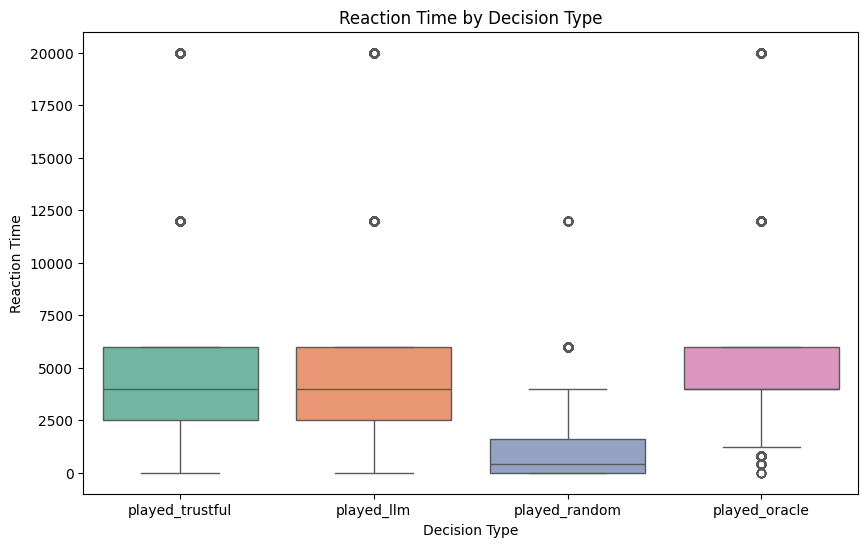

In [10]:
classification_label_column = 'reaction_time_bins_categories'
bin_edges = [-1] + [b[0] for b in reaction_time_bins] + [reaction_time_bins[-1][1]]
simulated_rt_df = pd.read_csv("/home/student/project/HumanChoicePredictionNLP/rt_data/simulated_rt_41.7_350.csv")
simulated_rt_df['reaction_time_bins'] = pd.cut(simulated_rt_df['rt'], bins=bin_edges, include_lowest=True)
simulated_rt_df['reaction_time_bins_categories'] = simulated_rt_df['reaction_time_bins'].apply(lambda x: (x.left)).astype(int)
display(simulated_rt_df.groupby('strategy')[['rt', 'reaction_time_bins_categories']].mean())
plt.figure(figsize=(10, 6))
sns.boxplot(x='strategy', y=classification_label_column, data=simulated_rt_df, palette='Set2', order=["history_and_review_quality (Trustful)", "LLM stochastic (Language-based)", "random", "correct - oracle"])
new_labels = ["played_trustful", "played_llm", "played_random", "played_oracle"]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
plt.title('Reaction Time by Decision Type')
plt.xlabel('Decision Type')
plt.ylabel('Reaction Time')
plt.show()

In [69]:
copy_train_df[copy_train_df['#wins_last_2_rounds'] == "0"][classification_label_column].astype(int).describe()

count    18989.000000
mean      3239.986308
std       4528.720512
min          0.000000
25%        400.000000
50%       1600.000000
75%       4000.000000
max      20000.000000
Name: reaction_time_bins_categories, dtype: float64

In [70]:
copy_train_df[copy_train_df['#wins_last_2_rounds'] == "1"][classification_label_column].astype(int).describe()

count    28284.000000
mean      3364.060953
std       4257.015889
min          0.000000
25%        400.000000
50%       1600.000000
75%       4000.000000
max      20000.000000
Name: reaction_time_bins_categories, dtype: float64

In [71]:
copy_train_df[copy_train_df['#wins_last_2_rounds'] == "2"][classification_label_column].astype(int).describe()

count    24306.000000
mean      4740.187608
std       4964.185680
min          0.000000
25%       1600.000000
50%       4000.000000
75%       6000.000000
max      20000.000000
Name: reaction_time_bins_categories, dtype: float64

In [15]:
X_processed_df[X_processed_df['played_random'] == 1]['reaction_time'].astype(int).describe()

count    1.714300e+04
mean     2.814542e+03
std      3.751968e+04
min      9.000000e+00
25%      1.710000e+02
50%      4.910000e+02
75%      2.373000e+03
max      4.498768e+06
Name: reaction_time, dtype: float64

In [16]:
X_processed_df[X_processed_df['played_oracle'] == 1]['reaction_time'].astype(int).describe()

count    1.238100e+04
mean     7.284241e+03
std      4.453011e+04
min      1.300000e+01
25%      1.558000e+03
50%      3.770000e+03
75%      7.489000e+03
max      3.971213e+06
Name: reaction_time, dtype: float64

In [17]:
X_processed_df[X_processed_df['played_llm'] == 1]['reaction_time'].astype(int).describe()

count    3.857000e+04
mean     7.044486e+03
std      6.831069e+04
min      9.000000e+00
25%      1.079000e+03
50%      2.918000e+03
75%      6.591500e+03
max      5.436177e+06
Name: reaction_time, dtype: float64

In [18]:
X_processed_df[X_processed_df['played_trustful'] == 1]['reaction_time'].astype(int).describe()

count    3.476100e+04
mean     6.781288e+03
std      6.217635e+04
min      9.000000e+00
25%      1.065000e+03
50%      2.831000e+03
75%      6.419000e+03
max      5.436177e+06
Name: reaction_time, dtype: float64

### Regression Modeling (Continous Representation)

In [34]:
all_features

['gameId',
 'roundNum',
 'user_points',
 'bot_points',
 'last_didGo_True',
 'last_last_didGo_True',
 'last_didWin_True',
 'last_last_didWin_True',
 'review_prob',
 'review_score',
 'review_length',
 'positive_review_proportion',
 'negative_review_proportion',
 'positive_negative_proportion',
 'negative_positive_proportion',
 'negative_score',
 'positive_score',
 'neutral_score',
 'compound_score',
 'current_game_mistakes_amount',
 'current_game_mistakes_percentage',
 'total_games_mistakes_percentage',
 'total_games_mistakes_amount',
 'user_earned_more',
 'bot_earned_more',
 'last_reaction_time',
 'last_reaction_time_bins_categories',
 'played_trustful',
 'played_llm',
 'played_random',
 'played_oracle']

In [86]:
X_train, y_train =  model_train_df[all_features], model_train_df[regression_label_column]
X_test, y_test = model_test_df[all_features], model_test_df[regression_label_column]

In [87]:
model = RandomForestRegressor(min_samples_leaf=50, max_depth=100)
model.fit(X_train[all_features], y_train)
y_pred = model.predict(X_test[all_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(rmse)

279.5389095660587


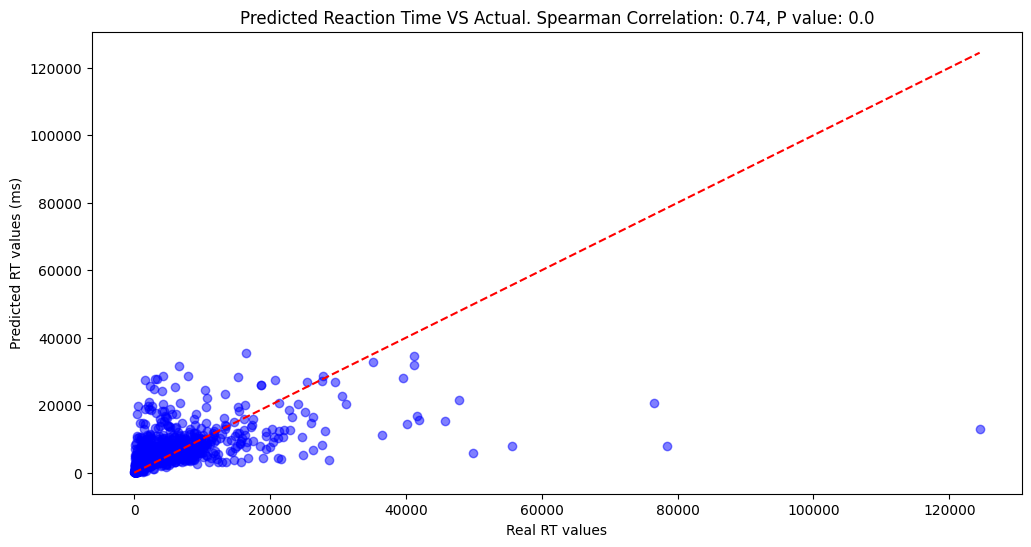

In [108]:
naive_model_rmse = np.sqrt(mean_squared_error(y_test, np.full(len(y_test), y_train.mean()), squared=False))
spearman, p_val = spearmanr(y_test, y_pred)
plt.figure(figsize=(12, 6))
np.random.seed(100)
random_indices = np.random.choice(len(y_test), size=1000, replace=False)
sorted_indices = np.argsort(y_test.iloc[random_indices])
sorted_y_test = y_test.iloc[random_indices].iloc[sorted_indices]
sorted_y_pred = y_pred[random_indices][sorted_indices]

plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.5)

# Plot diagonal line
max_val = max(sorted_y_test.max(), sorted_y_pred.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

# Set plot title with RMSE
plt.title(f"Predicted Reaction Time VS Actual. Spearman Correlation: {spearman:.2f}, P value: {p_val}")
plt.xlabel("Real RT values")
plt.ylabel("Predicted RT values (ms)")
plt.show()

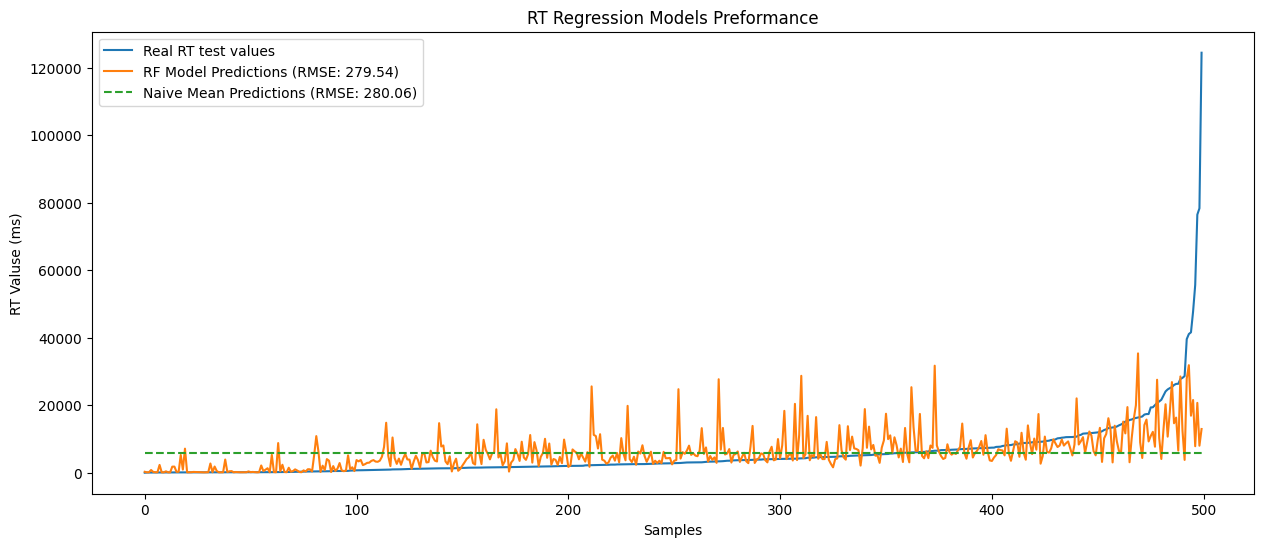

In [104]:
plt.figure(figsize=(15, 6))
np.random.seed(100)
random_indices = np.random.choice(len(y_test), size=500, replace=False)
sorted_indices = np.argsort(y_test.iloc[random_indices])
sorted_y_test = y_test.iloc[random_indices].iloc[sorted_indices]
sorted_y_pred = y_pred[random_indices][sorted_indices]
# Plot real y test values and predictions
plt.plot(sorted_y_test.reset_index(drop=True), label='Real RT test values')
plt.plot(sorted_y_pred, label=f'RF Model Predictions (RMSE: {round(rmse, 2)})')
plt.plot(np.full(500, y_train.mean()), label=f'Naive Mean Predictions (RMSE: {round(naive_model_rmse, 2)})', linestyle='dashed')

# Set plot title with RMSE
plt.title(f"RT Regression Models Preformance")
plt.xlabel("Samples")
plt.ylabel("RT Valuse (ms)")
plt.legend()
plt.show()

In [22]:
y_test_binned = pd.cut(y_test, bins=bin_edges, labels=labels, include_lowest=True)
y_pred_binned = pd.cut(y_pred, bins=bin_edges, labels=labels, include_lowest=True)

# Calculate accuracy
accuracy = accuracy_score(y_test_binned, y_pred_binned)
print("Accuracy:", accuracy)

# Calculate F1 score (use average='weighted' to handle class imbalance)
f1 = f1_score(y_test_binned, y_pred_binned, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_binned, y_pred_binned)
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels[1:], columns=bin_labels[1:])
print("Confusion Matrix:")
display(conf_matrix_df)

Accuracy: 0.323227913312261
F1 Score: 0.3163764746829656
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         6247     1253       591        322        460        402   
400-800        456      621       424        268        428        480   
800-1200        63      110       147        212        702       1034   
1200-1600       36       61        93        104        527       1039   
1600-2500       17       47        83         90        539       1860   
2500-4000       21       15        27         52        364       1897   
4000-6000        3        4        10         42        152       1084   
6000-12000       4        5        10         18         67        690   
12000-20000      0        1         0          5         11         97   
20000+           1        0         2          4         13         78   

             4000-6000  6000-12000  12000-20000  20000+  
0-400              263         169           17      11  
400-800            408         290           49      19  
800-1200           679         504           78      23  
1200-1600          836         690          133      59  
1600-2500         1859        1505          259      93  
2500-4000         2646        2329          358     136  
4000-6000         2351        2804          465     141  
6000-12000        2185        5010         1189     359  
12000-20000        398        1779          949     392  
20000+             235         801          755     644

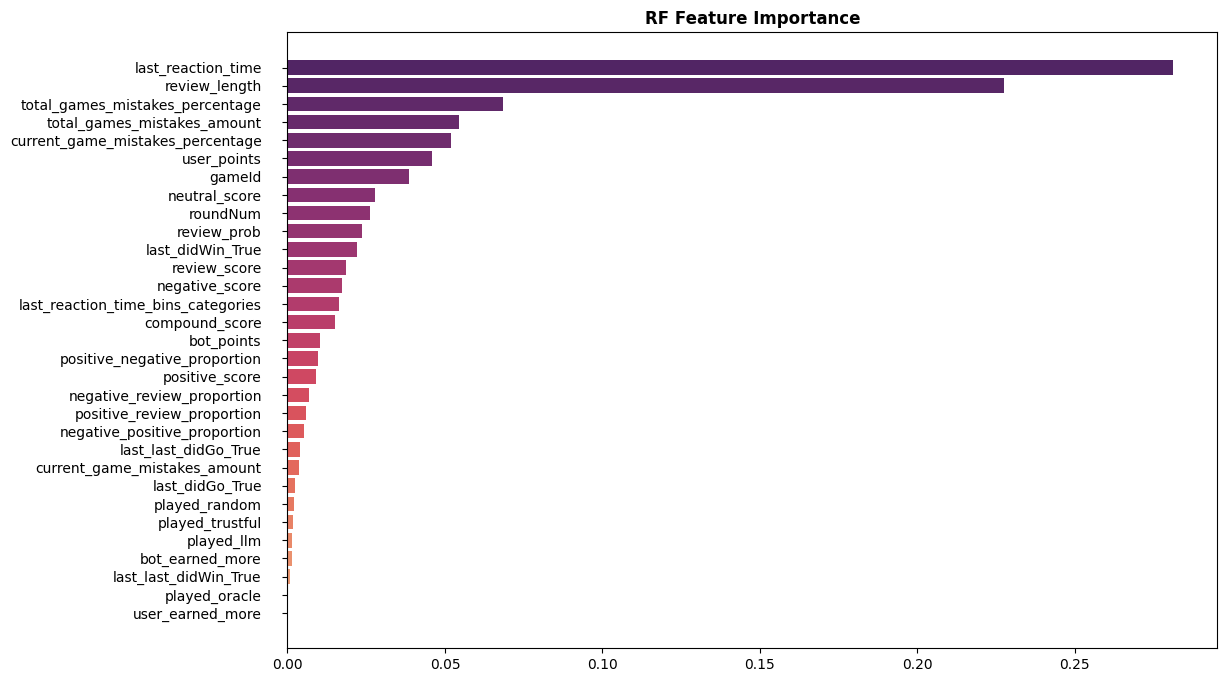

In [23]:
importances_df = pd.DataFrame({"feature_names" : model.feature_names_in_, "importances" : model.feature_importances_}).sort_values(by='importances', ascending=True)
colors = sns.color_palette("flare", len(model.feature_names_in_))

fig, ax = plt.subplots(figsize=(12,8))
ax.barh(importances_df["feature_names"], importances_df["importances"], color = colors)
ax.set_yticks(range(len(importances_df["feature_names"])))
ax.set_yticklabels(importances_df["feature_names"], fontsize=10)
ax.tick_params(axis='y', which='major', pad=15)
ax.set_title("RF Feature Importance", fontweight = "bold")
plt.grid(False)
plt.show()


In [24]:
selected_features = importances_df['feature_names'][-20:].tolist()

model = RandomForestRegressor(min_samples_leaf=50, max_depth=100)
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(rmse)

279.54687092912746


### Classification Modeling (Binning Representation)

In [109]:
all_features_classification = [feature for feature in all_features if feature != 'last_reaction_time']
X_train, y_train =  model_train_df[all_features_classification], model_train_df[classification_label_column]
X_test, y_test = model_test_df[all_features_classification], model_test_df[classification_label_column]

In [110]:
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[all_features_classification], y_train)
y_pred = classification_model.predict(X_test[all_features_classification])

In [112]:
train_mode = y_train.value_counts().idxmax()
naive_mode_predictions = np.full(len(y_test), train_mode)
accuracy_naive = accuracy_score(y_test, naive_mode_predictions)
print("Naive Model:")
print("Accuracy:", accuracy)

f1_naive = f1_score(y_test, naive_mode_predictions, average='weighted')
print("F1 Score:", f1)

Naive Model:
Accuracy: 0.16654733422978188
F1 Score: 0.047555746303875136


In [113]:
def evaluate_classification_model(model):
    num_estimators = len(model.estimators_)
    print(f"Number of estimators: {num_estimators}")
    tree_depths = [estimator.tree_.max_depth for estimator in model.estimators_]
    print(f"Depth of each tree: {tree_depths}")
    average_depth = sum(tree_depths) / num_estimators
    print(f"Average depth of trees: {average_depth}")
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score:", f1)
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels[1:], columns=bin_labels[1:])
    print("Confusion Matrix:")
    display(conf_matrix_df)
    return accuracy, f1

In [29]:
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [13, 13, 12, 11, 13, 14, 13, 14, 14, 13, 11, 14, 13, 14, 12, 13, 13, 15, 14, 11, 13, 14, 11, 14, 14, 12, 14, 12, 12, 13, 14, 11, 12, 12, 14, 14, 13, 13, 11, 14, 13, 12, 13, 13, 14, 12, 12, 13, 15, 12, 13, 13, 12, 12, 12, 12, 14, 13, 13, 12, 11, 13, 13, 12, 13, 12, 12, 13, 11, 12, 13, 13, 14, 14, 14, 12, 12, 13, 13, 14, 13, 12, 13, 15, 14, 13, 13, 11, 13, 12, 13, 12, 14, 12, 13, 14, 13, 14, 12, 14]
Average depth of trees: 12.86
Accuracy: 0.32654593716710617
F1 Score: 0.32263235544785507
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         7583     1494       318        104         44         61   
400-800        654     1694       528        186         64        115   
800-1200       125      787      1227        556        215        182   
1200-1600       89      564       864        718        332        290   
1600-2500       68      862      1043       1095        633        700   
2500-4000       61      752       872       1025        565       1009   
4000-6000       36      441       528        687        385        724   
6000-12000      47      411       473        577        391        605   
12000-20000      7      130       128        129         67        110   
20000+           9      111        84         69         52         60   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               51          13           27      40  
400-800             48          22           23     109  
800-1200           156          63           74     167  
1200-1600          212         118          127     264  
1600-2500          756         304          387     504  
2500-4000         1619         611          643     688  
4000-6000         1681         888          885     801  
6000-12000        1594        1649         2134    1656  
12000-20000        248         416         1128    1269  
20000+             119         159          493    1377

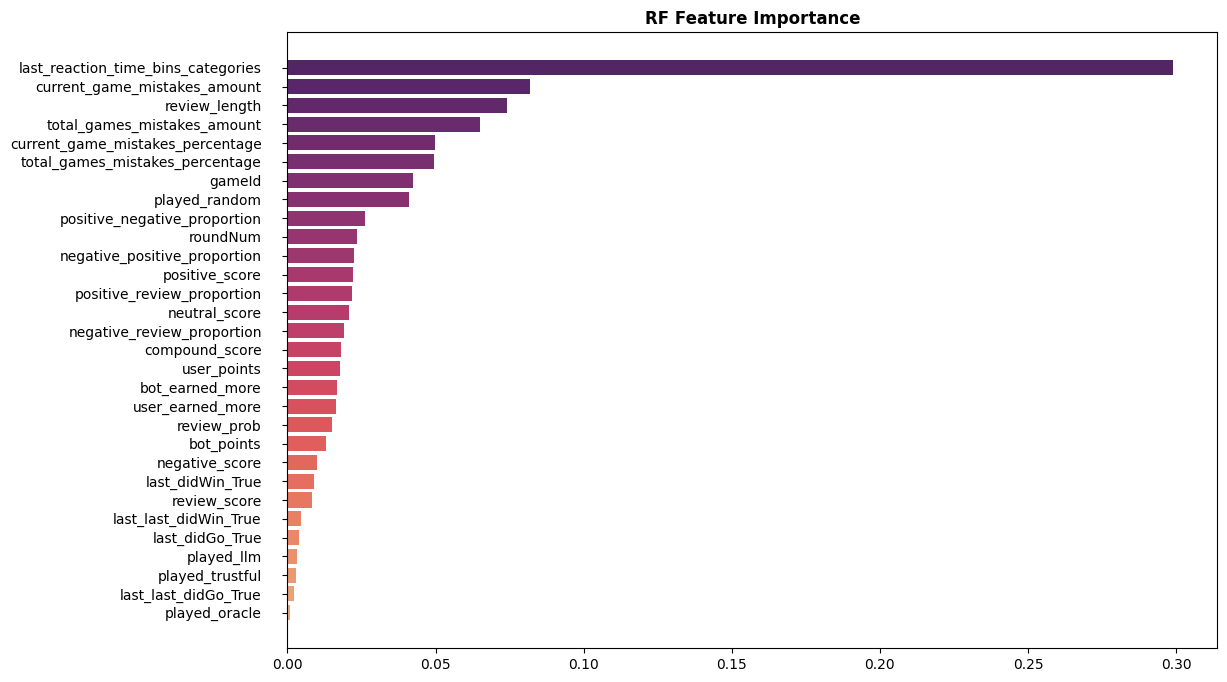

In [115]:
importances_df = pd.DataFrame({"feature_names" : classification_model.feature_names_in_, "importances" : classification_model.feature_importances_}).sort_values(by='importances', ascending=True)
colors = sns.color_palette("flare", len(classification_model.feature_names_in_))

fig, ax = plt.subplots(figsize=(12,8))
ax.barh(importances_df["feature_names"], importances_df["importances"], color = colors)
ax.set_yticks(range(len(importances_df["feature_names"])))
ax.set_yticklabels(importances_df["feature_names"],  fontsize=10)
ax.tick_params(axis='y', which='major', pad=15)
ax.set_title("RF Feature Importance", fontweight = "bold")
plt.grid(False)
plt.show()

In [31]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [11, 12, 12, 11, 12, 13, 13, 13, 13, 11, 12, 12, 13, 11, 12, 12, 14, 13, 12, 13, 12, 13, 14, 14, 13, 14, 13, 13, 14, 13, 13, 12, 15, 13, 12, 12, 11, 13, 12, 14, 12, 13, 12, 13, 13, 13, 13, 13, 12, 11, 12, 12, 12, 13, 12, 12, 13, 14, 14, 15, 12, 11, 13, 12, 12, 13, 12, 12, 12, 14, 14, 11, 13, 12, 12, 12, 12, 12, 12, 14, 12, 12, 13, 14, 13, 14, 13, 15, 14, 12, 11, 14, 12, 13, 12, 13, 11, 13, 13, 12]
Average depth of trees: 12.62
Accuracy: 0.3271920786546286
F1 Score: 0.32456802429144754
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         7493     1586       306        108         58         58   
400-800        578     1761       521        204         67         98   
800-1200       103      781      1282        535        220        162   
1200-1600       70      573       904        685        325        264   
1600-2500       44      818      1114       1072        635        662   
2500-4000       38      723       965        985        544       1008   
4000-6000       19      410       600        673        418        692   
6000-12000      24      381       496        592        396        583   
12000-20000      7      115       134        121         77        128   
20000+           4      109        94         69         53         74   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               48          15           25      38  
400-800             45          29           26     114  
800-1200           152          66           88     163  
1200-1600          234         129          122     272  
1600-2500          790         325          380     512  
2500-4000         1644         613          620     705  
4000-6000         1685         905          883     771  
6000-12000        1635        1692         2108    1630  
12000-20000        224         433         1129    1264  
20000+             102         161          501    1366

In [33]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=10, min_samples_leaf=20, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Average depth of trees: 10.0
Accuracy: 0.3380018511080453
F1 Score: 0.33734951491147436
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         7626     1513       255        112         72         60   
400-800        587     1758       500        213         87        109   
800-1200       106      736      1257        573        255        177   
1200-1600       64      507       893        703        391        310   
1600-2500       41      675      1085       1028        805        824   
2500-4000       35      593       908        915        667       1229   
4000-6000       23      355       539        593        485        853   
6000-12000      21      342       441        468        478        700   
12000-20000      6      112       112        109         81        146   
20000+           4      106        92         58         59         83   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               34          17           24      22  
400-800             42          24           29      94  
800-1200           143          84           92     129  
1200-1600          223         139          131     217  
1600-2500          733         385          367     409  
2500-4000         1584         709          626     579  
4000-6000         1654        1019          873     662  
6000-12000        1642        1866         2169    1410  
12000-20000        244         488         1177    1157  
20000+             110         179          562    1280

In [116]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=20, min_samples_leaf=20, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
accuracy, f1 = evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [19, 20, 15, 16, 16, 17, 16, 16, 18, 17, 16, 17, 16, 16, 18, 17, 17, 17, 17, 16, 18, 16, 16, 16, 17, 16, 15, 16, 18, 16, 15, 15, 17, 15, 17, 16, 16, 16, 14, 16, 16, 15, 17, 16, 18, 17, 18, 17, 18, 17, 16, 15, 18, 18, 18, 15, 15, 16, 16, 16, 14, 15, 17, 16, 16, 17, 19, 18, 16, 17, 17, 18, 14, 17, 16, 16, 19, 16, 17, 16, 16, 16, 15, 18, 16, 15, 17, 17, 16, 18, 16, 17, 16, 18, 17, 16, 17, 18, 17, 18]
Average depth of trees: 16.55
Accuracy: 0.34090075616017324
F1 Score: 0.34230945873187735
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         7621     1473       281        103         66         86   
400-800        591     1696       528        207        102        128   
800-1200       106      700      1237        574        284        214   
1200-1600       64      469       886        694        417        346   
1600-2500       41      645      1099        965        907        826   
2500-4000       34      532       915        857        816       1304   
4000-6000       22      333       507        568        546        944   
6000-12000      23      274       427        476        497        735   
12000-20000      6       99       109        105        108        126   
20000+           4       85        89         60         70         83   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               39          17           21      28  
400-800             40          30           31      90  
800-1200           137          90           96     114  
1200-1600          205         148          144     205  
1600-2500          715         391          361     402  
2500-4000         1487         754          599     547  
4000-6000         1555        1123          842     616  
6000-12000        1588        2112         2050    1355  
12000-20000        236         571         1161    1111  
20000+             112         203          593    1234

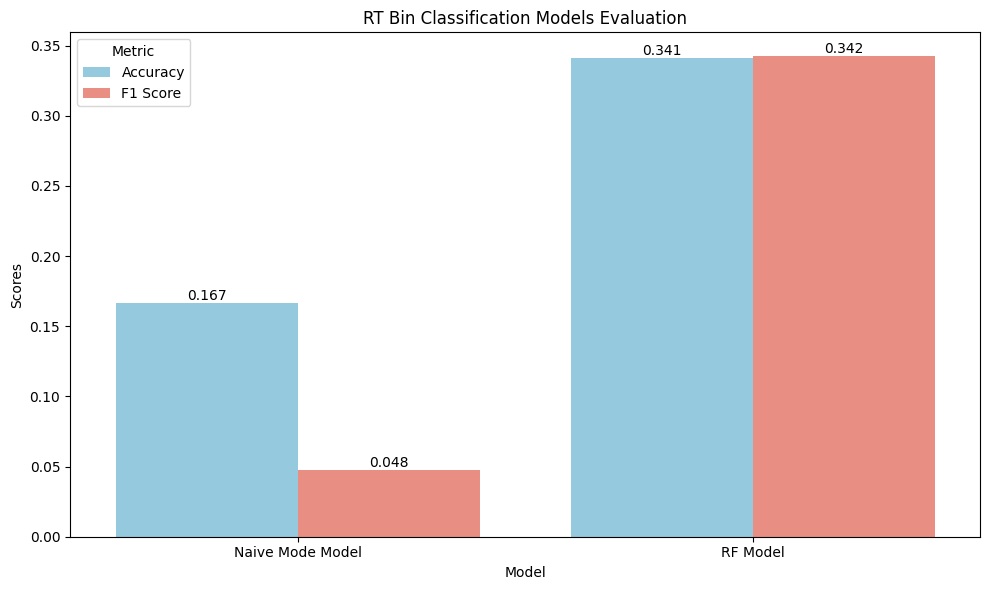

In [126]:
data = {
    'Model': ['Naive Mode Model', 'RF Model', 'Naive Mode Model', 'RF Model'],
    'Metric': ['Accuracy', 'Accuracy', 'F1 Score', 'F1 Score'],
    'Score': [accuracy_naive ,accuracy, f1_naive, f1]
}
df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Model', y='Score', hue='Metric', palette=['skyblue', 'salmon'])

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('RT Bin Classification Models Evaluation')

for p in ax.patches:
    height = p.get_height()
    if height > 0:  
        ax.text(
            p.get_x() + p.get_width() / 2, height,
            f'{height:.3f}',
            ha='center', va='bottom', color='black', fontsize=10
        )
plt.tight_layout()
plt.show()

In [35]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=20, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [11, 14, 12, 13, 12, 13, 12, 11, 14, 14, 11, 11, 12, 13, 11, 14, 12, 12, 15, 12, 12, 13, 11, 14, 11, 12, 12, 12, 12, 13, 14, 12, 12, 13, 13, 13, 12, 12, 11, 14, 13, 12, 12, 14, 12, 13, 11, 13, 13, 12, 13, 12, 13, 11, 13, 13, 12, 16, 13, 12, 13, 13, 14, 12, 12, 11, 12, 12, 13, 13, 11, 13, 12, 13, 12, 14, 13, 14, 12, 12, 13, 13, 13, 13, 13, 13, 12, 14, 14, 13, 13, 12, 12, 13, 11, 11, 12, 14, 12, 12]
Average depth of trees: 12.54
Accuracy: 0.32921781953442886
F1 Score: 0.32623413410513696
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         7605     1546       265         93         57         53   
400-800        592     1762       526        176         72        115   
800-1200       105      789      1257        533        223        156   
1200-1600       68      552       904        674        357        275   
1600-2500       39      783      1060       1090        711        699   
2500-4000       40      707       909        960        642        981   
4000-6000       23      393       542        665        457        733   
6000-12000      24      385       438        550        429        579   
12000-20000      7      122       114        105         83        124   
20000+           4      104        95         61         51         69   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               48          12           25      31  
400-800             44          22           18     116  
800-1200           149          73           93     174  
1200-1600          218         125          140     265  
1600-2500          746         340          368     516  
2500-4000         1643         624          648     691  
4000-6000         1679         917          880     767  
6000-12000        1672        1687         2157    1616  
12000-20000        252         432         1121    1272  
20000+             112         156          506    1375

In [36]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=20, min_samples_leaf=100, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [9, 10, 10, 10, 10, 9, 10, 10, 10, 13, 12, 12, 9, 9, 10, 9, 9, 10, 10, 9, 12, 9, 10, 10, 10, 9, 10, 9, 9, 11, 10, 9, 11, 9, 9, 10, 12, 12, 10, 9, 11, 10, 10, 10, 10, 11, 11, 9, 11, 9, 10, 11, 10, 10, 10, 13, 10, 9, 10, 12, 11, 10, 11, 10, 11, 10, 9, 10, 10, 10, 10, 10, 10, 10, 12, 9, 10, 11, 10, 10, 11, 9, 9, 11, 10, 10, 10, 10, 9, 12, 10, 10, 11, 9, 10, 10, 11, 9, 12, 10]
Average depth of trees: 10.14
Accuracy: 0.3185477533485846
F1 Score: 0.3115397830061662
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         7519     1525       353         95         45         44   
400-800        601     1755       547        171         63         73   
800-1200       108      825      1282        503        168        137   
1200-1600       68      623       921        658        251        226   
1600-2500       49      893      1113       1072        532        515   
2500-4000       38      837       954        992        484        754   
4000-6000       19      482       587        684        339        555   
6000-12000      24      472       491        600        337        446   
12000-20000      7      136       133        126         72         79   
20000+           5      121        99         59         42         43   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               52          15           31      56  
400-800             47          25           30     131  
800-1200           161          65           91     212  
1200-1600          263         111          141     316  
1600-2500          846         312          393     627  
2500-4000         1744         560          662     820  
4000-6000         1802         756          923     909  
6000-12000        1731        1400         2128    1908  
12000-20000        240         349         1086    1404  
20000+             115         143          453    1453

### Model Investigation

In [26]:
with open(rf'{dir_path}/models/updated_large_model_with_strategies_7.pkl', 'rb') as file:
    trained_model = pickle.load(file)

In [29]:
explainer = shap.TreeExplainer(trained_model.estimators_[0])
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[100], feature_names=list(trained_model.feature_names_in_))

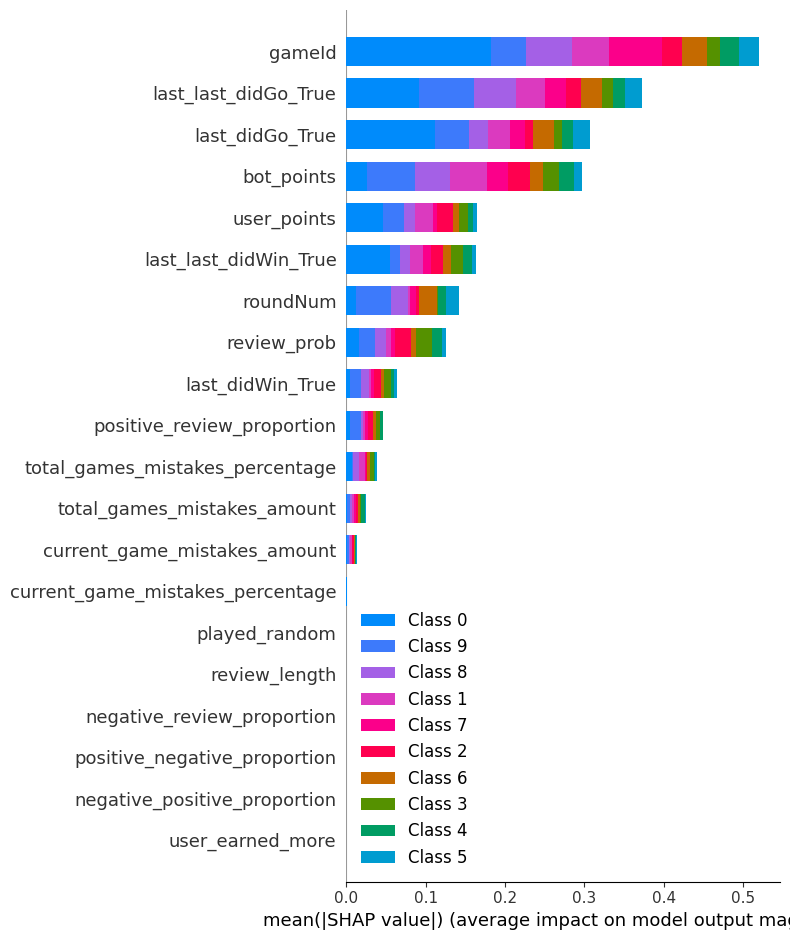

In [30]:
shap.summary_plot(shap_values, X_train)

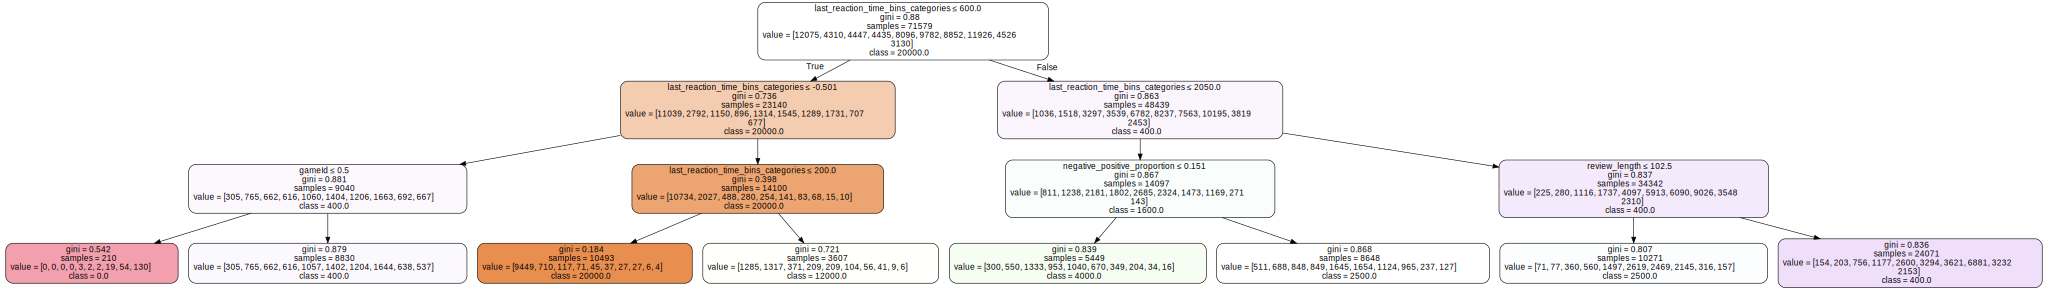

In [27]:
simple_model = DecisionTreeClassifier(max_depth=3)
simple_model.fit(X_train[list(trained_model.feature_names_in_)], y_train)
dot_data = export_graphviz(
    simple_model,
    out_file=None,
    feature_names=list(trained_model.feature_names_in_),
    class_names=[str(c) for c in y_train.unique()],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph

In [40]:
features = list(trained_model.feature_names_in_)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train[features].values, 
    feature_names=features,
    class_names=y_train.unique().tolist(), 
    discretize_continuous=True
)

# Explain the first instance in the training set
exp = explainer_lime.explain_instance(X_train[features].iloc[100].values, trained_model.estimators_[0].predict_proba, num_features=4)
exp.show_in_notebook(show_table=True)

In [41]:
features = list(trained_model.feature_names_in_)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train[features].values, 
    feature_names=features,
    class_names=y_train.unique().tolist(), 
    discretize_continuous=True
)

# Explain the first instance in the training set
exp = explainer_lime.explain_instance(X_train[features].iloc[100].values, trained_model.predict_proba, num_features=4)
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
